## 📌 LSTM 모델을 이용한 HYBE 주가 예측

### 사용변수 : 주식데이터 , 기술적보조지표, 트렌드, 이벤트, 감성지수 

In [1]:
#!pip install torchvision

In [2]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [3]:
plt.style.use('seaborn-whitegrid')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

C:\Users\wandong\AppData\Local\Temp\ipykernel_17652\1616429856.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 1. 데이터 형태 확인

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("../../../../data/FINALDATA/hybe.csv")
date=df['DATE']
df.set_index('DATE',inplace=True)
df

,Open,High,Low,Close,Volume,Change,MACD,Signal,PSAR,upper,...,OBV,FI,keyword,view_log_like_sum,view_log_like_avg,count,trend,DAY,SENTIMENT,EVENT
DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-02,174500.0,176000.0,166500.0,169500.0,183432.0,-0.023055,8471.944717,8743.872989,178985.200000,181776.516544,...,2022238.0,-7.337280e+08,50.67710,1.999836e+08,1.954167e+08,2.5,21.833970,월,77.917123,NaN
2023-01-03,170000.0,182000.0,170000.0,176500.0,522683.0,0.041298,8550.253289,8705.149049,166500.000000,183358.075528,...,2544921.0,3.658781e+09,64.10628,2.347509e+09,1.173754e+09,2.0,25.483202,화,181.407140,NaN
2023-01-04,176500.0,177000.0,169000.0,171500.0,251334.0,-0.028329,8115.306976,8587.180634,166500.000000,183065.294155,...,2293587.0,-1.256670e+09,58.39454,2.510606e+08,3.138258e+07,8.0,22.192699,수,381.612804,NaN
2023-01-05,172000.0,177000.0,171000.0,172000.0,173260.0,0.002915,7721.940982,8414.132704,166810.000000,182244.968256,...,2466847.0,8.663000e+07,56.27729,1.618707e+07,2.023384e+06,8.0,19.414286,목,558.004627,NaN
2023-01-06,170000.0,172000.0,160500.0,168000.0,509214.0,-0.023256,7006.660605,8132.638284,182000.000000,180174.782397,...,1957633.0,-2.036856e+09,58.21855,0.000000e+00,0.000000e+00,0.0,4.064204,금,413.298417,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,299000.0,303500.0,296000.0,298000.0,125709.0,-0.009967,8956.755842,8427.366351,282326.701011,313972.582010,...,6578958.0,-3.771270e+08,28.65975,1.216152e+08,1.311331e+07,4.0,14.639181,월,69.124696,-24.987417
2023-06-27,298500.0,298500.0,285500.0,292000.0,289388.0,-0.020134,8038.431782,8349.579437,284740.564931,314070.596224,...,6289570.0,-1.736328e+09,29.96373,5.750029e+07,1.437507e+07,4.0,20.525388,화,NaN,NaN
2023-06-28,294500.0,294500.0,284000.0,285000.0,166864.0,-0.023973,6668.936501,8013.450850,312500.000000,314011.048366,...,6122706.0,-1.168048e+09,31.50002,1.449860e+08,2.071228e+07,7.0,21.117770,수,NaN,NaN


In [5]:
df.isna().sum()

Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Change                0
MACD                  0
Signal                0
PSAR                  0
upper                 0
middle                0
lower                 0
SlowK                 0
SlowD                 0
ROC                   0
OBV                   0
FI                    0
keyword               0
view_log_like_sum     0
view_log_like_avg     0
count                 0
trend                 0
DAY                   0
SENTIMENT             4
EVENT                69
dtype: int64

In [6]:
df.loc[df['Close'].isna()]

,Open,High,Low,Close,Volume,Change,MACD,Signal,PSAR,upper,...,OBV,FI,keyword,view_log_like_sum,view_log_like_avg,count,trend,DAY,SENTIMENT,EVENT
DATE,,,,,,,,,,,,,,,,,,,,,


In [7]:
# df.drop(index='2023-05-05',inplace=True)

In [8]:
df.fillna(0,inplace=True)
df.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume               0
Change               0
MACD                 0
Signal               0
PSAR                 0
upper                0
middle               0
lower                0
SlowK                0
SlowD                0
ROC                  0
OBV                  0
FI                   0
keyword              0
view_log_like_sum    0
view_log_like_avg    0
count                0
trend                0
DAY                  0
SENTIMENT            0
EVENT                0
dtype: int64

In [9]:
drop_columns=['Close','view_log_like_sum','view_log_like_avg','count','DAY','keyword']

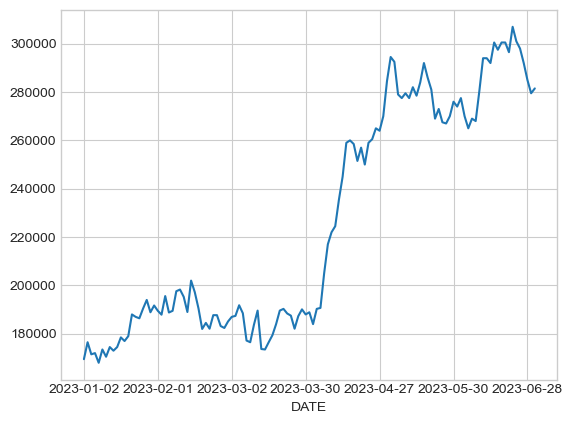

In [10]:
fig = df['Close'].plot()

In [11]:
X = df.drop(drop_columns, axis=1) # X, y 분리
y = df[['Close']]

In [12]:
X.fillna(0,inplace=True)
X.isna().sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, 2023-01-02 to 2023-06-30
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       123 non-null    float64
 1   High       123 non-null    float64
 2   Low        123 non-null    float64
 3   Volume     123 non-null    float64
 4   Change     123 non-null    float64
 5   MACD       123 non-null    float64
 6   Signal     123 non-null    float64
 7   PSAR       123 non-null    float64
 8   upper      123 non-null    float64
 9   middle     123 non-null    float64
 10  lower      123 non-null    float64
 11  SlowK      123 non-null    float64
 12  SlowD      123 non-null    float64
 13  ROC        123 non-null    float64
 14  OBV        123 non-null    float64
 15  FI         123 non-null    float64
 16  trend      123 non-null    float64
 17  SENTIMENT  123 non-null    float64
 18  EVENT      123 non-null    float64
dtypes: float64(19)
memory usage: 19.2+ KB


## 2. 8:2 로 train test 분리

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:99, :] 
X_test = X_ss[99:, :]

y_train = y_ms[:99, :]
y_test = y_ms[99:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (99, 19) (99, 1)
Testing Shape : (24, 19) (24, 1)


In [14]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (99, 19) (99, 1)
Testing Shape : (24, 19) (24, 1)


## 3. LSTM 모델 설정

In [15]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout_prob=0.0):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer added
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Applying dropout before the final fully connected layer
        out = self.fc(out)
        return out


In [16]:
num_epochs = 1500
learning_rate = 0.02

input_size=19 # 칼럼 개수
hidden_size=29 # 은닉층 유닛 개수
num_layers=1 # LSTM 계층 개수
dropout_prob = 0.3

num_classes=1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 오차 계산
    loss.backward() # 기울기 계산
    
    optimizer.step() # 오차 업데이트
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.16176
Epoch : 100, loss : 0.00005
Epoch : 200, loss : 0.00001
Epoch : 300, loss : 0.00000
Epoch : 400, loss : 0.00000
Epoch : 500, loss : 0.00000
Epoch : 600, loss : 0.00000
Epoch : 700, loss : 0.00000
Epoch : 800, loss : 0.00002
Epoch : 900, loss : 0.00000
Epoch : 1000, loss : 0.00000
Epoch : 1100, loss : 0.00001
Epoch : 1200, loss : 0.00000
Epoch : 1300, loss : 0.00000
Epoch : 1400, loss : 0.00000


In [18]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

## 4. 예측된 주식 값과 실제 주식 값을 시각화

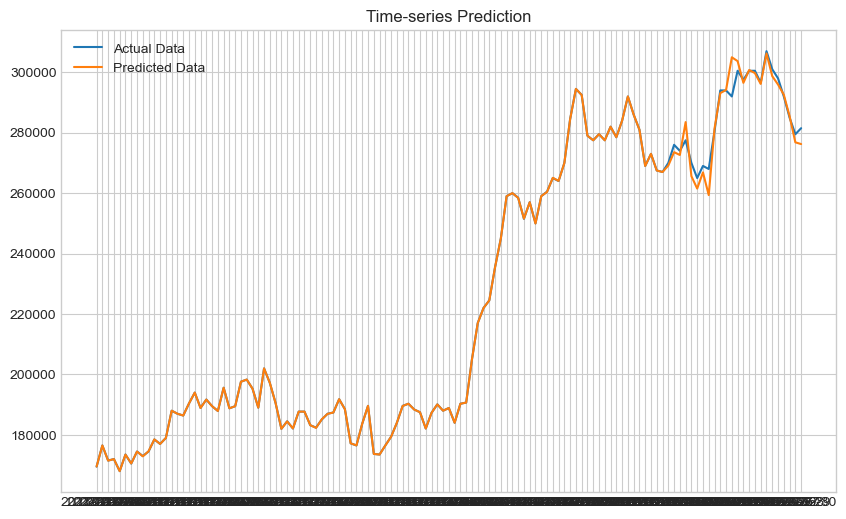

In [19]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
# plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

## 5. RMSE 계산

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 예측값과 실제값을 NumPy 배열로 변환
predicted = np.array(df['pred'])
actual = np.array(df['Close'])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {rmse}')


RMSE: 1762.4694422470272


## 6. 데이터 내보내기

In [21]:
HYBE_ALL_LSTM=pd.DataFrame({'DATE':date,'predicted':predicted,'actual':actual})
HYBE_ALL_LSTM.set_index('DATE',inplace=True)
HYBE_ALL_LSTM.to_csv('../../../../result/hybe/[LSTM] HYBE.csv',sep=',')
HYBE_ALL_LSTM

,predicted,actual
DATE,,
2023-01-02,169521.250000,169500.0
2023-01-03,176503.000000,176500.0
2023-01-04,171476.796875,171500.0
2023-01-05,171989.968750,172000.0
2023-01-06,168003.093750,168000.0
...,...,...
2023-06-26,295948.093750,298000.0
2023-06-27,292572.562500,292000.0
2023-06-28,285491.375000,285000.0
